# Ugrading the Autoencoder


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorcet as cc
from itertools import product
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Data Normalization

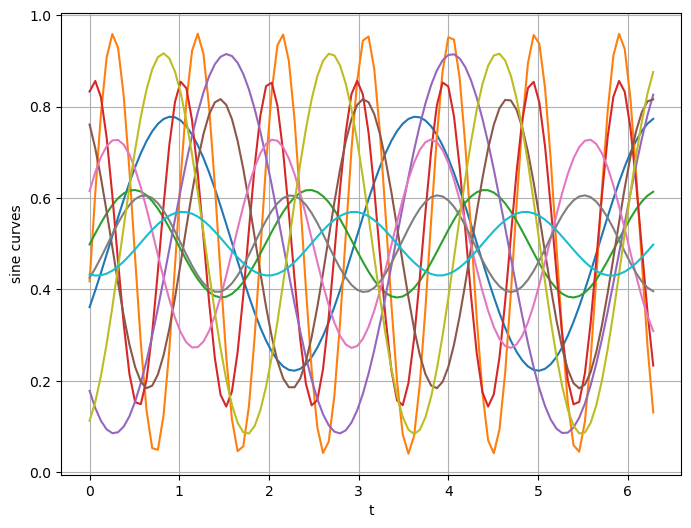

Training Data Min: 0.00034984558249327605, Max: 0.9998263091570978
Target Data Min: 0.0, Max: 1.0


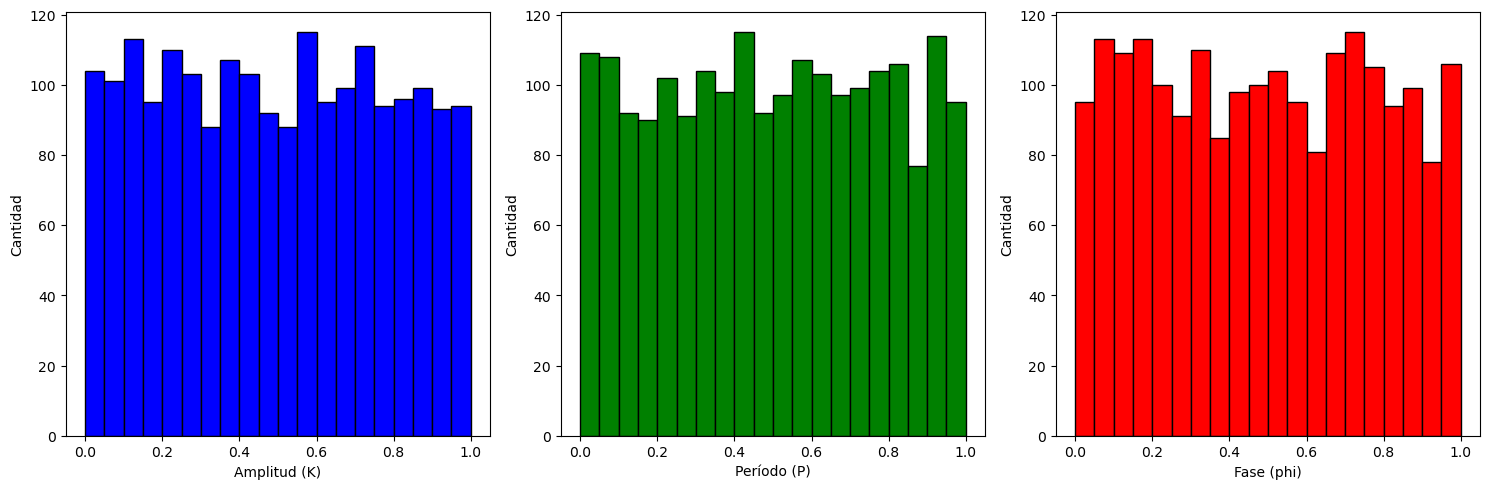

In [ ]:
data = np.loadtxt("Sinusoid_ML.dat")
P, K, phi = data[:, 0], data[:, 1], data[:, 2]


t = np.linspace(0, 2 * np.pi, 100)
#sine_curves = np.array([K[i] * np.sin(2 * np.pi * t / P[i] + 0) for i in range(len(P))])
sine_curves = data[:,3:103]
sine_curves = (sine_curves - sine_curves.min()) / (sine_curves.max() - sine_curves.min())

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(t, sine_curves[i], label=f'Curve {i+1}')

plt.xlabel("t")
plt.ylabel("sine curves")
plt.grid()
plt.show()


P_norm = (P - P.min()) / (P.max() - P.min())
K_norm = (K - K.min()) / (K.max() - K.min())
phi_norm = (phi - phi.min()) / (phi.max() - phi.min())
#phi_norm[:]=0


target_params = np.vstack([K_norm, P_norm, phi_norm]).T # transposta: cada fila 3 parametres

# 70% train, 15% val, 15% test
sine_train, sine_test, target_train, target_test = train_test_split(sine_curves, target_params, test_size=0.15, random_state=26)

print(f"Training Data Min: {sine_train.min()}, Max: {sine_train.max()}")
print(f"Target Data Min: {target_train.min()}, Max: {target_train.max()}")


#sine_train = torch.tensor(sine_train, dtype=torch.float32)
sine_train = torch.tensor(sine_train, dtype=torch.float32).reshape(-1, 1, 100)
# sine_test = torch.tensor(sine_test, dtype=torch.float32)
sine_test = torch.tensor(sine_test, dtype=torch.float32).reshape(-1, 1, 100)
target_train = torch.tensor(target_train, dtype=torch.float32)
target_test = torch.tensor(target_test, dtype=torch.float32)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(K_norm, bins=20, color='b', edgecolor='black')
plt.xlabel('Amplitud (K)')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 2)
plt.hist(P_norm, bins=20, color='g', edgecolor='black')
plt.xlabel('Período (P)')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 3)
plt.hist(phi_norm, bins=20, color='r', edgecolor='black')
plt.xlabel('Fase (phi)')
plt.ylabel('Cantidad')


plt.tight_layout()
plt.show()

### Autoencoder Bucle

#### Trying for 27 different hyperparameter configurations

In [66]:
epoch_list = [500,1500, 3000]
batch_list = [32, 64, 128]
lr_list = [0.001, 0.0005, 0.0001]
total_losses = []
for num_epochs in epoch_list:
    for batch_size in batch_list:
        for lr in lr_list:
            print('TRAINING:','epochs:', num_epochs, 'batch size:', batch_size,'lr:', lr)
            class AEConv(nn.Module):
                def __init__(self):
                    super(AEConv, self).__init__()
            
                    self.encoder_conv = nn.Sequential(
                        nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=4, out_channels=12, kernel_size=3, padding=1),
                        nn.ReLU()
                    )
                    
                    self.flatten = nn.Flatten()
                    
                    self.encoder_fc = nn.Sequential(
                        nn.Linear(12 * 100, 256),
                        nn.ReLU(),
                        nn.Linear(256, 64),
                        nn.ReLU(),
                        nn.Linear(64, 3),
                        nn.Tanh()
                    )
                    
                    self.decoder_fc = nn.Sequential(
                        nn.Linear(3, 64),
                        nn.ReLU(),
                        nn.Linear(64, 256),
                        nn.ReLU(),
                        nn.Linear(256, 12 * 100),
                        nn.ReLU()
                    )
                    self.unflatten = nn.Unflatten(1, (12, 100))
                    
                    self.decoder_conv = nn.Sequential(
                        nn.Conv1d(in_channels=12, out_channels=4, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.Conv1d(in_channels=4, out_channels=1, kernel_size=3, padding=1),
                        nn.Sigmoid()
                    )
            
                def forward(self, x):
                    x = self.encoder_conv(x)
                    x = self.flatten(x)
                    z = self.encoder_fc(x)
            
                    x = self.decoder_fc(z)
                    x = self.unflatten(x)
                    x = self.decoder_conv(x)
            
                    return x, z
            
            
            
            # Crear el modelo
            model = AEConv()
            
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            #num_epochs = 3000
            #batch_size = 64
            dataset = torch.utils.data.TensorDataset(sine_train, target_train)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            train_losses = []
            
            
            for epoch in range(num_epochs):
                model.train()
                running_train_loss = 0.0
                for batch_x, batch_y in dataloader:
                    optimizer.zero_grad()
                    outputs, latent = model(batch_x)
                    loss = criterion(outputs, batch_x)
                    loss.backward()
                    optimizer.step()
                    running_train_loss += loss.item() * batch_x.size(0)
                
            
                avg_train_loss = running_train_loss / len(dataloader.dataset)
                train_losses.append(avg_train_loss)
                if epoch % 10 == 0:
                    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.6f}")
            total_losses.append(train_losses)



TRAINING: epochs: 500 batch size: 32 lr: 0.001
Epoch [0/500], Train Loss: 0.047836
Epoch [10/500], Train Loss: 0.046249
Epoch [20/500], Train Loss: 0.046233
Epoch [30/500], Train Loss: 0.046218
Epoch [40/500], Train Loss: 0.046212
Epoch [50/500], Train Loss: 0.046210
Epoch [60/500], Train Loss: 0.046211
Epoch [70/500], Train Loss: 0.046209
Epoch [80/500], Train Loss: 0.046209
Epoch [90/500], Train Loss: 0.046208
Epoch [100/500], Train Loss: 0.046208
Epoch [110/500], Train Loss: 0.046208
Epoch [120/500], Train Loss: 0.046208
Epoch [130/500], Train Loss: 0.046208
Epoch [140/500], Train Loss: 0.046206
Epoch [150/500], Train Loss: 0.046205
Epoch [160/500], Train Loss: 0.046207
Epoch [170/500], Train Loss: 0.046209
Epoch [180/500], Train Loss: 0.046207
Epoch [190/500], Train Loss: 0.046208
Epoch [200/500], Train Loss: 0.046206
Epoch [210/500], Train Loss: 0.046205
Epoch [220/500], Train Loss: 0.046205
Epoch [230/500], Train Loss: 0.046206
Epoch [240/500], Train Loss: 0.046205
Epoch [250/500

In [ ]:
np.save("total_losses.npy", np.array(total_losses, dtype=object)) # saving the data

### Plot of the results 

/tmp/ipykernel_5222/947662660.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(combinations))


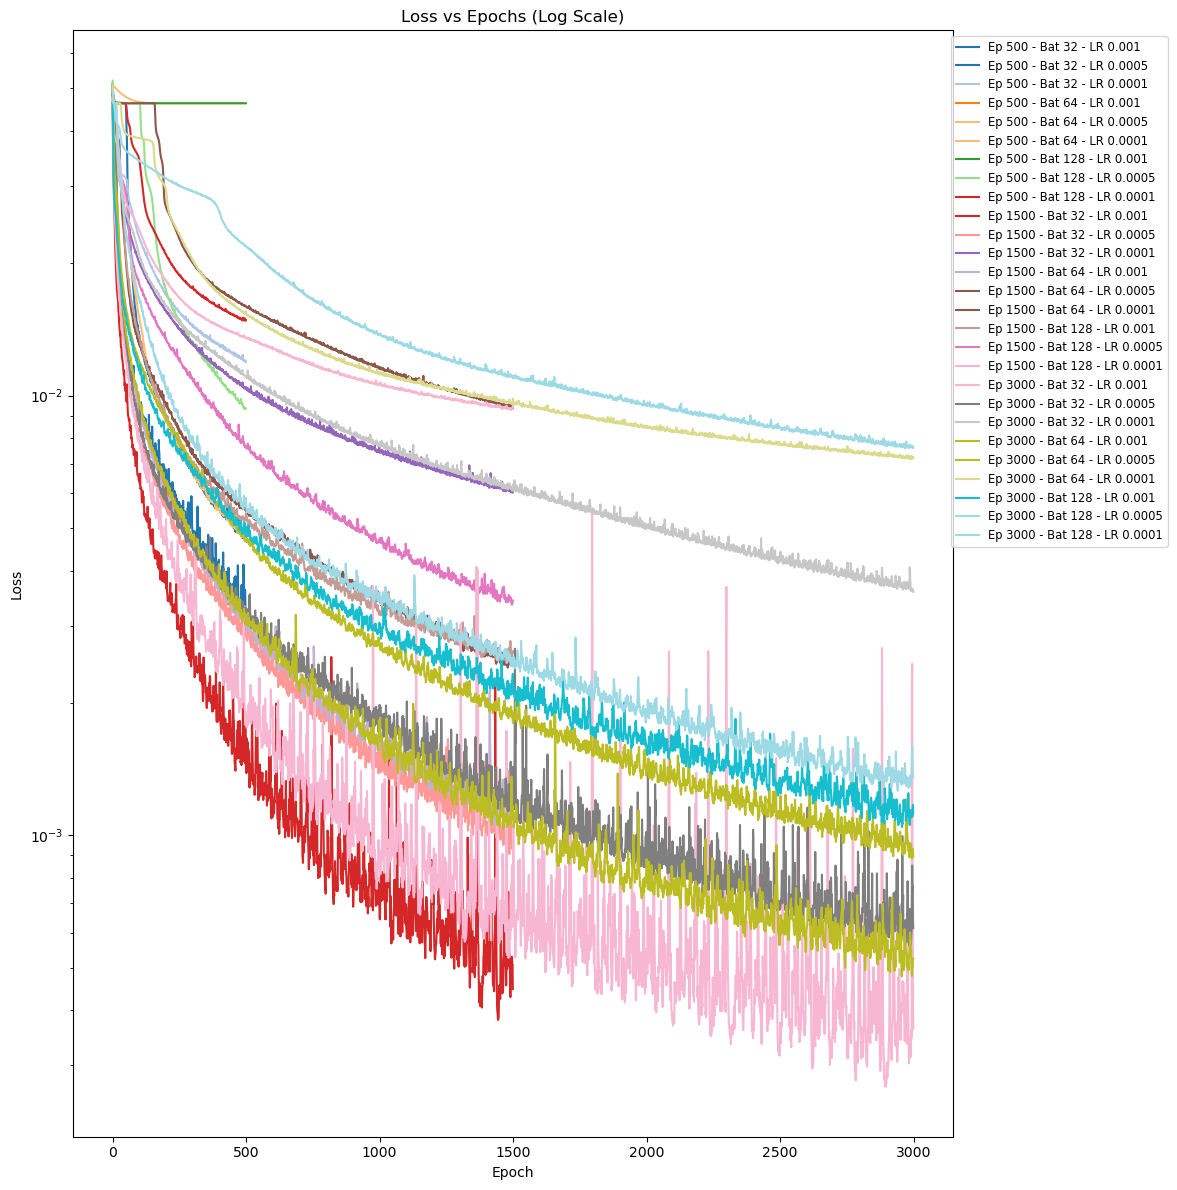

In [132]:
loaded = np.load("total_losses.npy", allow_pickle=True)
total_losses = loaded.tolist()

lenght = len(epoch_list)*len(batch_list)*len(lr_list)
epoch_list = [500,1500, 3000]
batch_list = [32, 64, 128]
lr_list = [0.001, 0.0005, 0.0001]


combinations = list(product(epoch_list, batch_list, lr_list))  # length = 27
colors = cm.get_cmap('tab20', len(combinations))

plt.figure(figsize=(12, 12))

for i, (epoch, batch, lr) in enumerate(combinations):
    plt.plot(total_losses[i], label=f"Ep {epoch} - Bat {batch} - LR {lr}", color=colors(i))

plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Log Scale)")
plt.legend(fontsize='small', loc='upper right', bbox_to_anchor=(1.25, 1.0))  # para que quepan más
plt.tight_layout()
plt.savefig('loss_epochs.png')
plt.show()